# 02. Data Preprocessing & Feature Engineering

**Objective:** Transform the raw dataset into a clean, numerical format suitable for machine learning algorithms.

**Key Concepts Applied:**
* **Data Leakage Prevention:** Strictly fitting imputation and scaling parameters *only* on the Training set.
* **Handling Skewness:** Applying Log Transformation to `annual_income` to correct the right-skewed distribution observed in EDA.
* **Concept Hierarchy Climbing:** Reducing `grade_subgrade` (high cardinality) to `grade` (ordinal) to manage dimensionality.
* **Encoding:** Converting categorical variables (Nominal & Ordinal) into numeric representations.

In [23]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add project root to path
sys.path.append(os.path.abspath('..'))

from src.sml_homework.data_loader import load_and_split_data
from src.sml_homework.preprocessing import clean_and_encode_data, scale_features

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load Data

We reload the stratified split to ensure we start with a clean slate.

In [24]:
X_train, X_val, y_train, y_val = load_and_split_data('../data/raw/train.csv')

print(f"Training Features: {X_train.shape}")
print(f"Validation Features: {X_val.shape}")

Training Features: (475195, 12)
Validation Features: (118799, 12)


## 2. The "Before" State

In our EDA, we identified `annual_income` as highly skewed. Let's capture its state before any transformation to demonstrate the impact of our transformation.

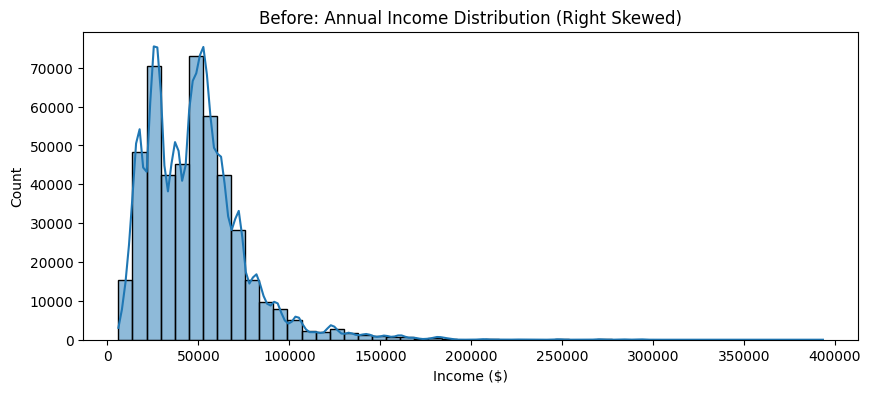

In [25]:
plt.figure(figsize=(10, 4))
sns.histplot(X_train['annual_income'], bins=50, kde=True)
plt.title("Before: Annual Income Distribution (Right Skewed)")
plt.xlabel("Income ($)")
plt.show()

## 3. Data Cleaning & Encoding

We apply the `clean_and_encode_data` function. 

**Anti-Leakage Step:**
1.  **Train:** We pass `imputation_values=None`. The function *calculates* the median from X_train and returns it.
2.  **Validation:** We pass the *saved* `imputation_values`. The function uses X_train's median to fill X_val.

This ensures no information from the validation set leaks into our imputation logic.

In [26]:
# 1. Process Training Data (LEARN the stats)
X_train_clean, learned_medians = clean_and_encode_data(X_train, imputation_values=None)

# 2. Process Validation Data (APPLY the stats)
X_val_clean, _ = clean_and_encode_data(X_val, imputation_values=learned_medians)

# Verification
print("Learned Medians from Train:", learned_medians)
print("\nMissing values in Train after cleaning:", X_train_clean.isnull().sum().sum())
print("Missing values in Val after cleaning:", X_val_clean.isnull().sum().sum())

Learned Medians from Train: {}

Missing values in Train after cleaning: 0
Missing values in Val after cleaning: 0


### Effect of Log Transformation

Our cleaning function applied `np.log1p` to `annual_income`. Let's see the result.

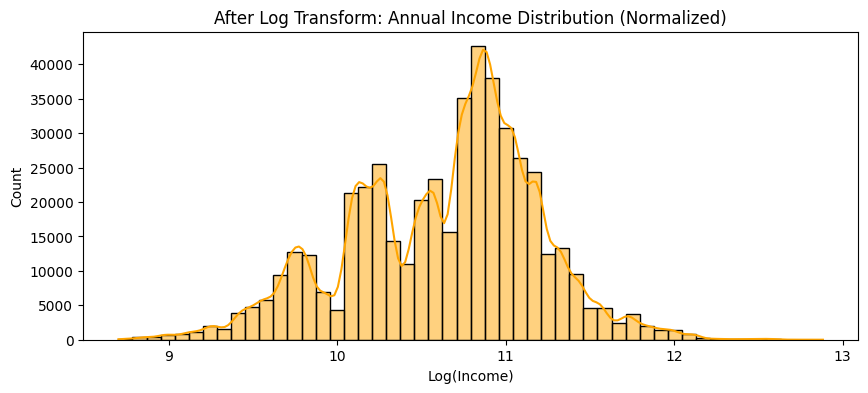

In [27]:
plt.figure(figsize=(10, 4))
sns.histplot(X_train_clean['annual_income'], bins=50, kde=True, color='orange')
plt.title("After Log Transform: Annual Income Distribution (Normalized)")
plt.xlabel("Log(Income)")
plt.show()

## 4. Feature Scaling (Standardization)

We apply Z-Score Standardization ($ \frac{x - \mu}{\sigma} $). 
Just like imputation, we must **Fit** on Train and **Transform** on Validation.

In [28]:
X_train_scaled, X_val_scaled = scale_features(X_train_clean, X_val_clean)

print("Scaling Complete.")
print(f"Mean of scaled income: {X_train_scaled['annual_income'].mean():.4f} (Should be ~0)")
print(f"Std of scaled income: {X_train_scaled['annual_income'].std():.4f} (Should be ~1)")

Scaling Complete.
Mean of scaled income: 0.0000 (Should be ~0)
Std of scaled income: 1.0000 (Should be ~1)


## 5. Final Output Verification

We check the final shape and data types to ensure all categorical text has been converted to numbers (One-Hot or Ordinal) and the data is ready for the modeling phase.

In [29]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 475195 entries, 501345 to 383829
Data columns (total 17 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   annual_income                    475195 non-null  float64
 1   debt_to_income_ratio             475195 non-null  float64
 2   credit_score                     475195 non-null  float64
 3   loan_amount                      475195 non-null  float64
 4   interest_rate                    475195 non-null  float64
 5   gender                           475195 non-null  object 
 6   marital_status                   475195 non-null  object 
 7   education_level                  475195 non-null  object 
 8   employment_status                475195 non-null  object 
 9   grade_encoded                    475195 non-null  int64  
 10  loan_purpose_Car                 475195 non-null  int64  
 11  loan_purpose_Debt consolidation  475195 non-null  int64  
 12  lo

## 6. Save Processed Data

We save the processed dataframes to `data/processed` so our Modeling notebook can load them directly without re-running this pipeline. We use Parquet format for efficiency and to preserve data types.

In [30]:
# Create output directory
output_dir = '../data/processed'
os.makedirs(output_dir, exist_ok=True)

# Save Features using 'fastparquet' engine to avoid PyArrow crash
X_train_scaled.to_parquet(f'{output_dir}/X_train_scaled.parquet', engine='fastparquet')
X_val_scaled.to_parquet(f'{output_dir}/X_val_scaled.parquet', engine='fastparquet')

# Save Targets
y_train.to_frame().to_parquet(f'{output_dir}/y_train.parquet', engine='fastparquet')
y_val.to_frame().to_parquet(f'{output_dir}/y_val.parquet', engine='fastparquet')

print(f"Files saved to {output_dir}")

Files saved to ../data/processed
